# A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import set_config
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


### Define functions for later use

In [2]:
# 
# Graphing helper
# 
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [3]:
#
# eps: Max distance between two samples to be considered neighbours
# min_samples: Minimum number of points to form a dense region
#
# called with a range of eps and min_sample values, returns results as a dataframe
#
def run_dbscan_on_range(data, eps_values, min_samples_values):
    results = []

    for eps in eps_values:
        
        for min_samples in min_samples_values:
            
            db = DBSCAN(eps=eps, min_samples=min_samples)
            
            labels = db.fit_predict(data)
            
            # Count clusters (excluding noise), which has value -1
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # get silhouette score
            if n_clusters > 1:
                score = silhouette_score(data, labels)
            else:
                score = -1  # -1 is noise

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': score
            })

    return pd.DataFrame(results)

# Load the dataset

In [4]:
df = pd.read_csv("./bank.csv")

# keep a copy 
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


# B. Exploratory Data Analysis and Data Preparation¶

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [6]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28.0,admin.,single,secondary,no,127,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81.0,retired,married,primary,no,1154,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46.0,services,married,primary,no,4343,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40.0,entrepreneur,married,secondary,no,6403,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,1823.000000,11.000000,854.000000,55.000000


balance and pdays has negative values

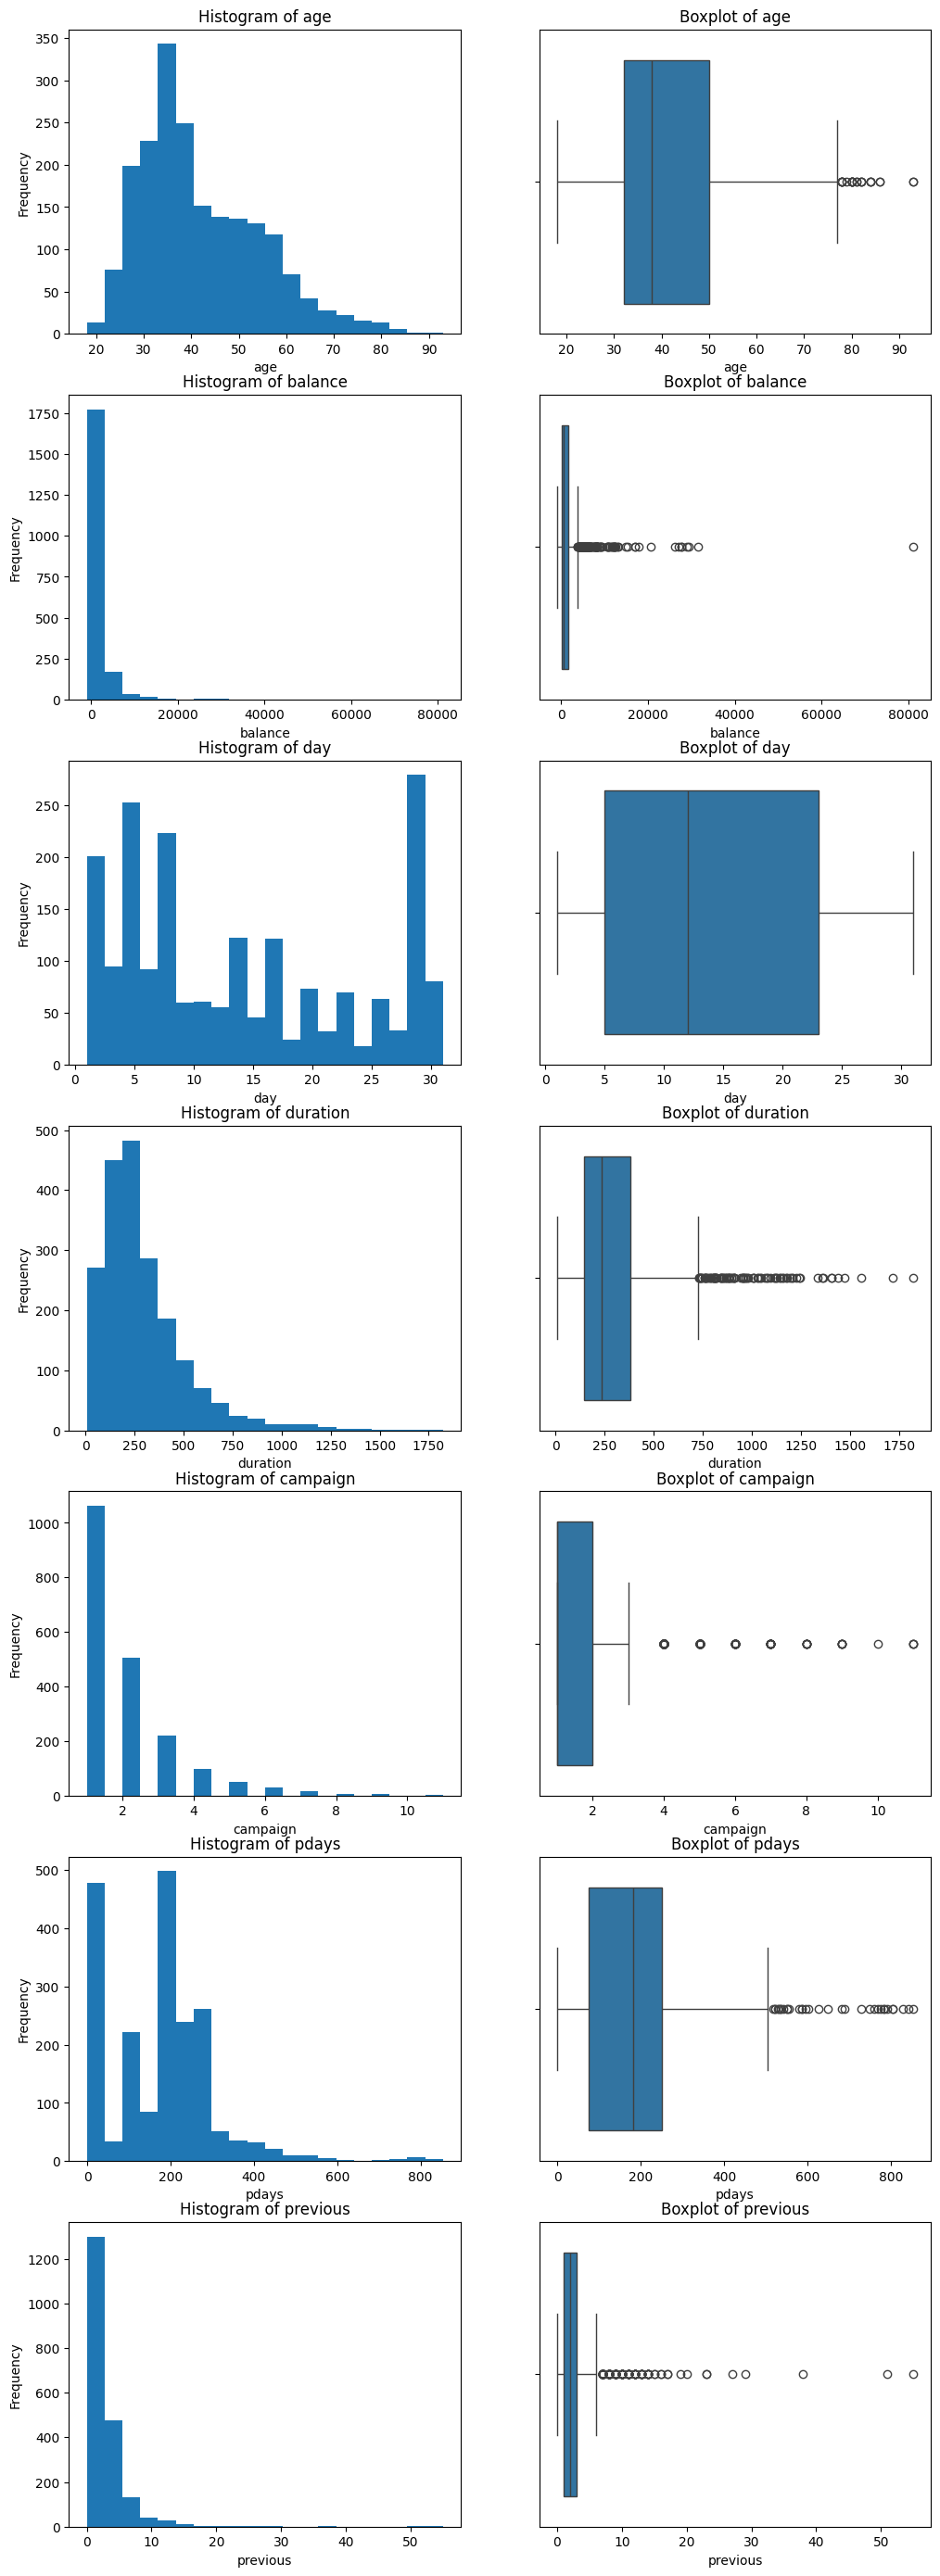

In [8]:
cols = ['age','balance','day','duration','campaign','pdays','previous']

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12,35))    

for row, column in enumerate(cols):

    axes[row,0].hist(df[column], bins=20)
    axes[row,0].set_title(f'Histogram of {column}')
    axes[row,0].set_xlabel(column)
    axes[row,0].set_ylabel('Frequency')

    # Put boxplot in 2nd col
    sns.boxplot(data=df, x=column, ax=axes[row][1])
    
    axes[row,1].set_title(f'Boxplot of {column}')
    axes[row,1].set_xlabel(column)

plt.show()


**Everything except day has outliers and seems right skewed, so**
1. Use Minmaxscaler for days as its a known range
1. Use RobustScalar for others as they've outliers
1. 

# Task 1: Data Preparation Pipeline

## Drop columns that we don't want to avoid data leakage

In [9]:
# Drop columns that we don't want to avoid data leakage
df.drop(columns=['duration'], inplace=True) 
df.drop(columns=['subscribed'], inplace=True) 


## Encode Ordinal Features

#### Education

In [10]:
# Create a dictionary for education

education_dictionary = {
    "primary" : 0,
    "secondary" : 1,
    "tertiary" : 2
}

df['education'] = df['education'].replace(education_dictionary)
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,2,-1,0,NaN
1996,28.0,admin.,single,1,no,127,no,no,cellular,16,sep,2,-1,0,NaN
1997,81.0,retired,married,0,no,1154,no,no,telephone,17,sep,1,-1,0,NaN
1998,46.0,services,married,0,no,4343,yes,no,NaN,20,sep,1,-1,0,NaN
1999,40.0,entrepreneur,married,1,no,6403,no,no,cellular,22,sep,2,-1,0,NaN


#### Month

In [11]:
# Create a dictionary for month
calendar_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                  'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

df['month'] = df['month'].replace(calendar_dict)
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,9,2,-1,0,NaN
1996,28.0,admin.,single,1,no,127,no,no,cellular,16,9,2,-1,0,NaN
1997,81.0,retired,married,0,no,1154,no,no,telephone,17,9,1,-1,0,NaN
1998,46.0,services,married,0,no,4343,yes,no,NaN,20,9,1,-1,0,NaN
1999,40.0,entrepreneur,married,1,no,6403,no,no,cellular,22,9,2,-1,0,NaN


#### Deal with Zero or negative values
The data has negative values.  Add a delta to attributes with a negative value, to make them positive.

In [12]:
df.describe()

,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,11.000000,854.000000,55.000000


In [13]:
# get min values for attributes
columns = ['balance','pdays','previous']


for col in columns:
    shift_value = abs(df[col].min()) + 2  # Ensures no negative or zero
    df[col] = np.log(df[col] + shift_value)

df.describe()


,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,7.511862,13.851500,1.909500,4.229232,1.357902
std,12.724358,0.647772,9.712189,1.378862,1.983043,0.527848
min,18.000000,0.693147,1.000000,1.000000,0.693147,0.693147
25%,32.000000,7.076231,5.000000,1.000000,4.366263,1.098612
50%,38.000000,7.334982,12.000000,1.000000,5.220356,1.386294
75%,50.000000,7.873407,23.000000,2.000000,5.537334,1.609438
max,93.000000,11.316740,31.000000,11.000000,6.753438,4.043051


#### Check for Missing Values

In [14]:
print(df.dtypes)

age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
campaign       int64
pdays        float64
previous     float64
poutcome      object
dtype: object


In [15]:
### Check for missing values.  .sort_values(ascending=False)
print ('number of values missing for column')
df.isna().sum()[df.isna().sum() > 0].sort_index(ascending=True)



number of values missing for column


age           12
contact      191
education    104
job           10
poutcome     454
dtype: int64

#### Imput Poutcome
From the first assignment, we decided to set nulls here to not_contacted.

In [16]:
# Looks like poutcome won't be filled out if they haven't been contacted before, which is reasonable.  For these rows, imput not_contacted
df['poutcome']=df['poutcome'].fillna('not_contacted')


## Create Imput Missing Values Pipeline
1. Use Median for age
1. Use Mode for Education, Contact and Job
1. Add constant string, NOT_CONTACTED for poutcome

right skewed attributes were age','balance','duration','pdays','previous

### Pipeline Approach
|Type| Attribute    | Imput | Scale| One Hot Encode|Comment|
|-----|-------------|-----|------------|--------|----|
|Numerical| age   | most_frequent  | Robust   |||
|Numerical| balance     |  | Robust  |||
|Categorical| campaign |   | Robust    |||
|Categorical| contact   | most_frequent  | |Yes   ||
|| day     |   | MinMaxScaler  |||
|Categorical| default |  |  |Yes||
|Categorical-Ordinal| education   | most_frequent  |    |Yes|Used Mapper above to transform to ordinal|
|Categorical| housing     |  |  |Yes||
|Categorical| job | most_frequent  |  |Yes||
|Categorical| loan   |   |    |Yes||
|Categorical| marital     |  |  |Yes||
|Categorical-Ordinal| month |   | MinMaxScaler    ||Used Mapper above to transform|
|Numerical| pdays     |   | Robust  |||
|Categorical| poutcome | Done outside pipeline  |     |Yes|Manually Imput NOT_CONTACTED for N/As above, perhaps use MissingIndicator Imputter |
|Numerical| previous |   | Robust    |||numerical_attribute_scale_using_robust

In [17]:
# pipeline definition
numerical_attribute = ['age','balance','day','pdays','previous']
numerical_attribute_scale_using_min_max = ['day']
numerical_attribute_scale_using_robust=['age','balance','pdays','previous']

categorical_attribute = ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']


num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', ColumnTransformer(
                transformers=[
                        ('scale_using_min_max',MinMaxScaler(),numerical_attribute_scale_using_min_max),
                        ('scale_using_robust',RobustScaler(),numerical_attribute_scale_using_robust)
                        ]
                )
    )
    ]
)

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(sparse_output=False)) # sparse output required for fit_transform
])

col_transform = ColumnTransformer(transformers=[
        ('num_pipeline',num_pipeline,numerical_attribute),
        ('cat_pipeline',cat_pipeline,categorical_attribute)
    ], remainder='drop', n_jobs=-1)



preprocess_pipeline = Pipeline(steps=[
    ('preprocess', col_transform), 
    
])

# run the pipeline
df_post_col_transform = preprocess_pipeline.fit_transform(df)


# Task 2: k-Means

### Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.

#### Elbow Method

Optimal number of clusters (k): 2


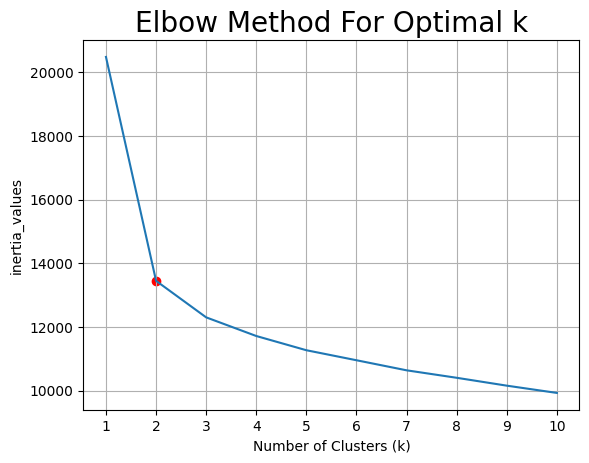

In [18]:
# Interia is the sum of the squared distance of the point and its centroid
inertia_values = []

# KMeans args
#  n_clusters : The number of clusters to form as well as the number of centroids to generate.
# ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia
# max_iter : iterations per run
# n_init : Number of times the k-means algorithm is run with different centroid seeds
# random_state : Determines random number generation for centroid initialization

#
#
# Loop through a range of k values (1 to 10 for example)
for k in range(1, 11):
 
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    model.fit(df_post_col_transform)  # Fit the k-Means model
    
    inertia_values.append(model.inertia_)  # Inertia is the sum of squared distances

kl = KneeLocator(range(1, 11), inertia_values, curve="convex", direction="decreasing" )

print(f"Optimal number of clusters (k): {kl.elbow}")

# Plotting the Elbow Method graph
plt.plot(range(1, 11), inertia_values)
plt.xticks(range(1, 11))
plt.scatter(kl.elbow, inertia_values[kl.elbow - 1], color='red', label='Elbow')
plt.style.use("fivethirtyeight")
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('inertia_values')
plt.grid(True)
plt.show()


#### Silhouette Coefficient

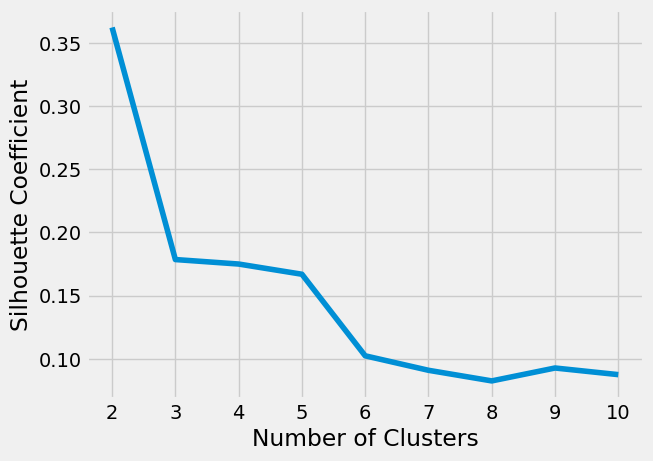

Optimal number of clusters (k) based on Silhouette Score: 2


In [19]:
silhouette_coefficients = []
 
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    model.fit(df_post_col_transform)  # Fit the k-Means model
    
    score = silhouette_score(df_post_col_transform, model.labels_)
    
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# Print the best k with the highest silhouette score
best_k = range(2, 11)[silhouette_coefficients.index(max(silhouette_coefficients))]

print(f"Optimal number of clusters (k) based on Silhouette Score: {best_k}")

#### Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
The Elbow and Silhouette score suggests 2 is the best value for k.  

In [20]:
best_k = 2

model = KMeans(n_clusters=best_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
model.fit(df_post_col_transform)  # Fit the k-Means model

# Append the cluster centers to the preprocessed dataset.
data_and_centers = np.r_[df_post_col_transform,model.cluster_centers_]



transformation complete


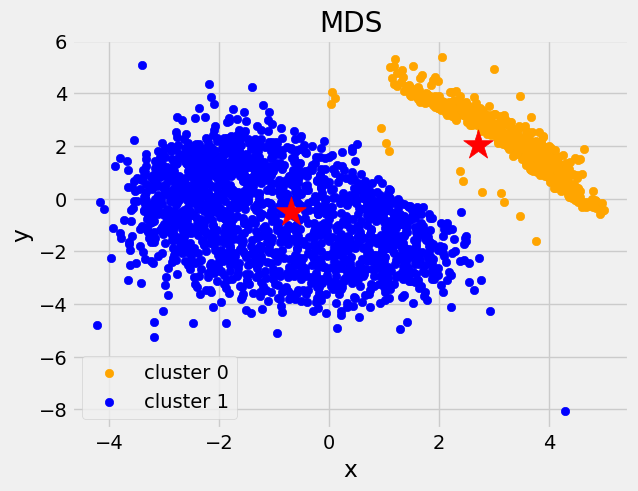

In [21]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=model.labels_, 
                       centers=XYcoordinates[-best_k:,:], 
                       title='MDS')

transformation complete
(2002, 2)
<class 'pandas.core.frame.DataFrame'>


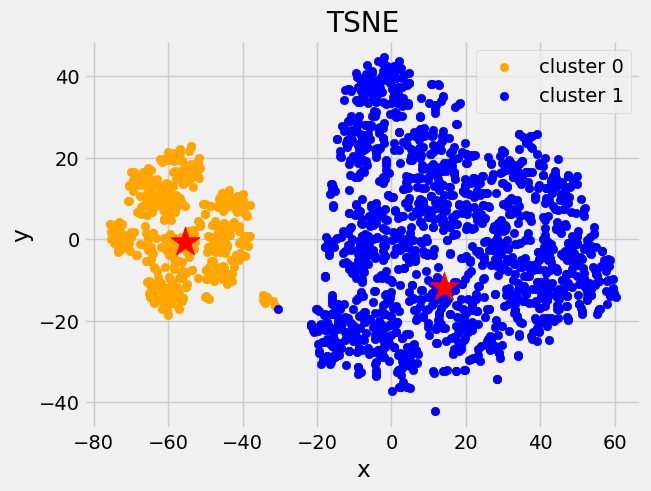

In [22]:
# 
# 
## 
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

print(XYcoordinates.shape)  
print(type(XYcoordinates))

# convert to NumPy array - TODO - see why
XYcoordinates = np.array(XYcoordinates)

clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=model.labels_,
                       centers=XYcoordinates[-best_k:,:], 
                       title='TSNE')


#### Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters 

df['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

# DBSCAN

In [23]:
# Lets run DBScan with 15 EPS values from 0.25 to 4, min_samples of 5..15
eps_range = np.linspace(0.25, 4, num=15);

min_samples_range  = np.arange(5, 15, step =1)

results_df = run_dbscan_on_range(df_post_col_transform, eps_range, min_samples_range)

results_df[results_df['silhouette'] != -1].sort_values(by='silhouette', ascending=False)





,eps,min_samples,n_clusters,n_noise,silhouette
94,2.660714,9,2,36,0.300180
93,2.660714,8,2,36,0.300180
92,2.660714,7,2,36,0.300180
99,2.660714,14,2,47,0.298181
96,2.660714,11,2,40,0.297082
...,...,...,...,...,...
31,1.053571,6,8,1930,-0.297609
41,1.321429,6,12,1902,-0.298385
30,1.053571,5,16,1888,-0.301786
40,1.321429,5,19,1867,-0.303245


#### Conclusion
An eps of 2.660714 and 7-9 samples gave the best silhouette score.  It suggested 2 clusters.  Run + Graph DBScan with these values

In [24]:
eps = 2.660714
min_samples = 9

db = DBSCAN(eps=eps, min_samples=min_samples)
            
dbscan_cluster_labels = db.fit_predict(df_post_col_transform)

transformation complete


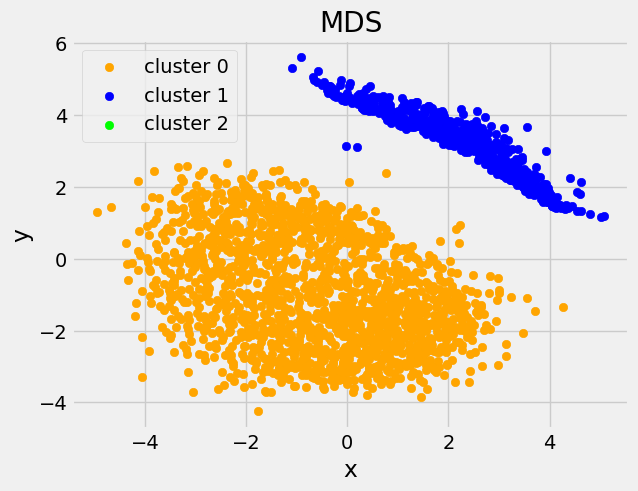

In [25]:


XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(df_post_col_transform)

print("transformation complete")

clustering_scatterplot(points=XYcoordinates, 
                       labels=dbscan_cluster_labels, 
                       centers=None, 
                       title='MDS')


transformation complete
(2000, 2)
<class 'pandas.core.frame.DataFrame'>


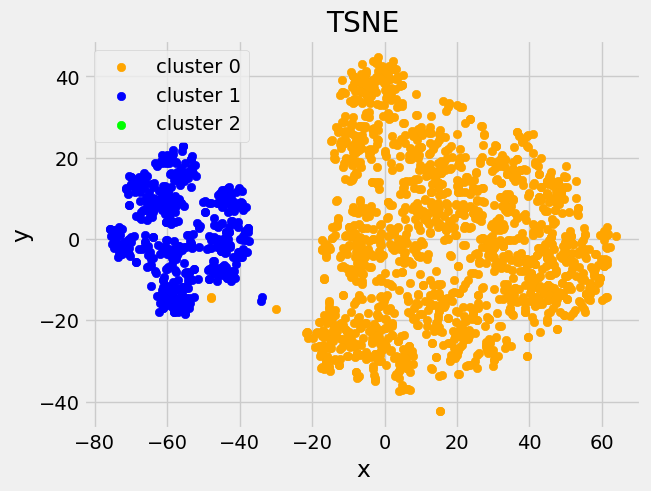

In [26]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(df_post_col_transform)
print("transformation complete")

print(XYcoordinates.shape)  
print(type(XYcoordinates))

# convert to NumPy array - TODO - see why
XYcoordinates = np.array(XYcoordinates)

clustering_scatterplot(points=XYcoordinates, 
                       labels=dbscan_cluster_labels,
                       centers=None, 
                       title='TSNE')


In [27]:
#### Cluster Summary
# Number of clusters
n_clusters = len(set(dbscan_cluster_labels)) - (1 if -1 in dbscan_cluster_labels else 0)
print(f"Number of clusters: {n_clusters}")

# Count of members in clusters
unique, counts = np.unique(dbscan_cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(cluster_sizes)

#
df_for_analysis = df_original;
df_for_analysis['cluster'] = dbscan_cluster_labels
cluster_summary = df_for_analysis.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)




Number of clusters: 2
{np.int64(-1): np.int64(36), np.int64(0): np.int64(1510), np.int64(1): np.int64(454)}
               age   balance        day  campaign     pdays  previous
cluster                                                              
-1       47.861111  8.110371  12.611111  2.972222  4.131030  2.109359
 0       42.327552  7.514941  14.230464  1.921192  5.293822  1.539126
 1       39.366446  7.454162  12.689427  1.786344  0.696201  0.695567


In [28]:
df[df['cluster'] == -1].describe()

,age,balance,day,campaign,pdays,previous,cluster
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0
mean,47.861111,8.110371,12.611111,2.972222,4.131030,2.109359,-1.0
std,16.948920,1.762686,9.871395,2.248633,1.868011,0.863476,0.0
min,26.000000,0.693147,1.000000,1.000000,0.693147,0.693147,-1.0
25%,34.000000,7.184439,4.000000,1.000000,1.861792,1.609438,-1.0
50%,42.000000,8.141734,9.500000,2.000000,4.952244,1.945910,-1.0
75%,59.000000,9.081541,19.250000,3.500000,5.507307,2.583476,-1.0
max,84.000000,11.316740,30.000000,9.000000,6.658011,4.043051,-1.0


In [29]:
df[df['cluster'] == 0].describe()

,age,balance,day,campaign,pdays,previous,cluster
count,1499.000000,1510.000000,1510.000000,1510.000000,1510.000000,1510.000000,1510.0
mean,42.327552,7.514941,14.230464,1.921192,5.293822,1.539126,0.0
std,12.397461,0.607419,10.242060,1.389543,0.487905,0.416003,0.0
min,19.000000,5.509388,1.000000,1.000000,2.079442,1.098612,0.0
25%,33.000000,7.092574,4.000000,1.000000,5.198497,1.098612,0.0
50%,39.000000,7.343102,13.000000,1.000000,5.308268,1.386294,0.0
75%,51.000000,7.877679,25.000000,2.000000,5.575949,1.791759,0.0
max,93.000000,10.263886,31.000000,11.000000,6.753438,3.367296,0.0


In [30]:
df[df['cluster'] == 1].describe()

,age,balance,day,campaign,pdays,previous,cluster
count,453.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.0
mean,39.366446,7.454162,12.689427,1.786344,0.696201,0.695567,1.0
std,13.052241,0.592208,7.571471,1.209122,0.045955,0.037652,0.0
min,18.000000,5.365976,1.000000,1.000000,0.693147,0.693147,1.0
25%,30.000000,7.023313,8.000000,1.000000,0.693147,0.693147,1.0
50%,36.000000,7.283791,8.000000,1.000000,0.693147,0.693147,1.0
75%,46.000000,7.753624,17.000000,2.000000,0.693147,0.693147,1.0
max,86.000000,10.238065,31.000000,11.000000,1.386294,1.386294,1.0


In [31]:
# 454 is a familiar number - is one of hte cluster not_contacted
df_for_analysis.groupby('cluster')['poutcome'].value_counts(normalize=True)

cluster  poutcome     
-1       failure          0.472222
         success          0.250000
         other            0.222222
         not_contacted    0.055556
 0       failure          0.621192
         success          0.286755
         other            0.092053
 1       not_contacted    0.995595
         success          0.004405
Name: proportion, dtype: float64

# D. K-Means Clustering
The k-Means clustering algorithm has the number of clusters, k, as an input parameter n_clusters. 
We construct a final pipeline for training a k-Means clustering model for a fixed value of n_clusters = 3. 
The final pipeline has the preprocessing pipeline as its first step followed by the scikit-learn KMeans algorithm as a second step.

Plot the transformed examples and the centers. Use the cluster assignment to colour the examples

#
# for debug save intermediate state
# 

df.tail()
transformed_df = pd.DataFrame(df)
transformed_df.to_csv('before_transformed_data.csv', index=False)

transformed_df.tail();

df.describe();

In [ ]:


#preprocess_pipeline
X_debug = col_transform.fit_transform(df)
print ('debug',X_debug);

#.toarray(), columns=pipeline.named_steps['onehot'].get_feature_names_out(['contact'])
transformed_df = pd.DataFrame(X_debug)

# Save the transformed data to a CSV file
transformed_df.to_csv('transformed_data.csv', index=False)



clustering_model = pipe.fit(df)

# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)

Misc Workings